# Combined Categorical and Continious model information defiusion in tweet cascades

In [1]:
#import dependencies
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

#tf.enable_eager_execution() # must be run on a start up program

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

import datetime
import pandas as pd
import numpy as np
import random
import pydot
import graphviz
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import plot_model
from IPython.display import Image


Instructions for updating:
Use the retry module or similar alternatives.
TensorFlow version: 1.7.0
Eager execution: False


Using TensorFlow backend.


In [2]:
# Resources used: 
#https://www.tensorflow.org/get_started/eager

In [3]:
# load in the data

metadata_file = '/Users/jaspermeijering/Google Drive/a Study/EPA Study Abroad - Carnegie Mellon University/Courses/CMU - 95845 - Applied Analytics The Machine Learning Pipeline/Machine Learning Pipeline Final Project/Data/FalseNews_Code_Data/data/metadata_anon.txt'

# Read meta data 
fin = open(metadata_file,'r')
lines = fin.readlines()
fin.close()
cascade_id2metadata={}
for line in lines:
    line = line.replace('\n','')
    item = eval(line)
    cascade_id2metadata[item[0]] = item[1]

    # Get static measures
veracity = []
virality = []
depth = []
breadth = []
size = []
verified = []
nfollowers = []
nfollowees = []
engagement = []
category = []
day = []
hour = []
cascadeID= []

for cascade,metadata in cascade_id2metadata.items():
    veracity.append(metadata['veracity'])
    virality.append(metadata['virality'])
    depth.append(metadata['depth'])
    breadth.append(metadata['max_breadth'])
    size.append(metadata['size'])
    verified.append(metadata['verified_list'][0])
    nfollowers.append(metadata['num_followers_list'][0])
    nfollowees.append(metadata['num_followees_list'][0])
    engagement.append(metadata['engagement_list'][0])
    category.append(metadata['rumor_category'])
    day.append(metadata['start_date'].day)
    hour.append(metadata['start_date'].hour)
    cascadeID.append(cascade) # for merging models

# Convert to data frame
df = pd.DataFrame({'cid':cascadeID,'veracity': veracity, 'virality': virality, 'depth': depth, 'breadth': breadth, 'size': size, 'verified': verified, 'nfollowers': nfollowers, 
                   'nfollowees': nfollowees, 'engangement': engagement, 'category': category, 'day': day, 'hour': hour})

# Inspect
df.head(5)


,breadth,category,cid,day,depth,engangement,hour,nfollowees,nfollowers,size,veracity,verified,virality
0,1,Politics,1,22,0,7.092405,21,236.0,164.0,1,FALSE,False,NaN
1,1,Politics,10,23,0,8.394500,14,1999.0,870.0,1,FALSE,False,NaN
2,1,Politics,100,9,0,6.729679,16,1982.0,452.0,1,FALSE,False,NaN
3,1,Politics,1000,15,0,0.186418,20,55.0,5.0,1,FALSE,False,NaN
4,1,Politics,10000,14,0,1.425915,14,129.0,95.0,1,FALSE,False,NaN


In [4]:
df_saved = df


In [5]:
df = df_saved


### Make data numeric

In [6]:
# Make category numeric
df["category"] = df["category"].astype('category')
df["category_num"] = df.category.cat.rename_categories([1,2,3,4,5,6,7])
df["category_num"] = df["category_num"].astype('int')
print("Transformed categories to numeric values, this is how they match",df.category.unique(),df.category_num.unique())

# Make veracity numeric
df["veracity"] = df["veracity"].astype('category')
df["veracity_num"] = df.veracity.cat.rename_categories([1,2,3])
df["veracity_num"] = df["veracity_num"].astype('int')
print("Transformed veracity to numeric values, this is how they match",df.veracity.unique(),df.veracity_num.unique())

# Make verified numeric
df["verified_cat"] = df["verified"].astype('category')
df["verified_cat"] = df["verified_cat"].cat.set_categories(["True","False","None"])
#df["verified_cat"].isnull().sum() # 136 nan / none values for verified
df.loc[df["verified_cat"].isnull(),'verified'] = "None" # -> leave these cascades in. # this is wrong
df["verified_num"] = df.verified_cat.cat.rename_categories([1,2,3])
df["verified_num"] = df["verified_num"].astype('int')
print("Transformed verified to numeric values, this is how they match",df.verified.unique(),df.verified_num.unique())

#df.dtypes
df.head()


Transformed categories to numeric values, this is how they match [Politics, Viral Photos/Stories/Urban Legends, War/Terrorism/Shootings, Science/Nature/Tech/Food/Health, Entertainment, Business, Natural Disasters]
Categories (7, object): [Politics, Viral Photos/Stories/Urban Legends, War/Terrorism/Shootings, Science/Nature/Tech/Food/Health, Entertainment, Business, Natural Disasters] [4 6 7 5 2 1 3]
Transformed veracity to numeric values, this is how they match [FALSE, TRUE, MIXED]
Categories (3, object): [FALSE, TRUE, MIXED] [1 3 2]
Transformed verified to numeric values, this is how they match ['None'] [-9223372036854775808]


,breadth,category,cid,day,depth,engangement,hour,nfollowees,nfollowers,size,veracity,verified,virality,category_num,veracity_num,verified_cat,verified_num
0,1,Politics,1,22,0,7.092405,21,236.0,164.0,1,FALSE,None,NaN,4,1,NaN,-9223372036854775808
1,1,Politics,10,23,0,8.394500,14,1999.0,870.0,1,FALSE,None,NaN,4,1,NaN,-9223372036854775808
2,1,Politics,100,9,0,6.729679,16,1982.0,452.0,1,FALSE,None,NaN,4,1,NaN,-9223372036854775808
3,1,Politics,1000,15,0,0.186418,20,55.0,5.0,1,FALSE,None,NaN,4,1,NaN,-9223372036854775808
4,1,Politics,10000,14,0,1.425915,14,129.0,95.0,1,FALSE,None,NaN,4,1,NaN,-9223372036854775808


# verified is wrong

### Drop NaN values for virality. 

In [7]:
print(df.virality.isnull().sum(),"of",len(df),"cascades are single tweet cascades. These tweets were not retweeded. \
We are only interessted in rumours that have been spread and want to predict the veracity based on how information deffused \
These sigle tweets will therefor be dropped from the dataset.")

df = df[np.isfinite(df['virality'])]
df.head(10)

84220 of 126301 cascades are single tweet cascades. These tweets were not retweeded. We are only interessted in rumours that have been spread and want to predict the veracity based on how information deffused These sigle tweets will therefor be dropped from the dataset.


,breadth,category,cid,day,depth,engangement,hour,nfollowees,nfollowers,size,veracity,verified,virality,category_num,veracity_num,verified_cat,verified_num
7777,10703,Viral Photos/Stories/Urban Legends,106998,28,11,25.799399,9,186.0,672.0,23228,MIXED,None,4.003857,6,2,NaN,-9223372036854775808
7778,11783,Science/Nature/Tech/Food/Health,106999,1,9,10.811974,6,313.0,380.0,14827,MIXED,None,2.535338,5,2,NaN,-9223372036854775808
7782,6504,Viral Photos/Stories/Urban Legends,107000,27,13,15.395237,21,518.0,504.0,14129,MIXED,None,4.019705,6,2,NaN,-9223372036854775808
7783,5772,Viral Photos/Stories/Urban Legends,107001,22,8,3.140842,4,189.0,228.0,9972,MIXED,None,3.271008,6,2,NaN,-9223372036854775808
7784,6041,Viral Photos/Stories/Urban Legends,107002,21,8,5.160261,23,174.0,110.0,9526,MIXED,None,3.115942,6,2,NaN,-9223372036854775808
7785,6160,Entertainment,107003,10,8,11.310233,0,846.0,842.0,9124,MIXED,None,2.971147,2,2,NaN,-9223372036854775808
7786,2110,Viral Photos/Stories/Urban Legends,107004,28,14,20.554899,6,542.0,716.0,6203,MIXED,None,5.110521,6,2,NaN,-9223372036854775808
7787,3092,Viral Photos/Stories/Urban Legends,107005,13,10,4.256828,4,364.0,179.0,5882,MIXED,None,3.633757,6,2,NaN,-9223372036854775808
7788,4971,Politics,107006,29,3,4.325858,15,417.0,637.0,5075,MIXED,None,2.041730,4,2,NaN,-9223372036854775808
7789,3374,Viral Photos/Stories/Urban Legends,107007,11,5,29.216077,13,910.0,1140.0,4305,MIXED,None,2.584301,6,2,NaN,-9223372036854775808


### Only keep relevant columns

In [8]:
# Only keep relevant columns
column_names_df = ['cid','veracity_num','breadth', 'category_num', 'depth', 'engangement', 'day','nfollowees', 'nfollowers', 'size', 'verified_num', 'virality']
column_names_x =['cid','breadth', 'category_num', 'depth', 'engangement', 'day','nfollowees', 'nfollowers', 'size', 'verified_num', 'virality']
column_names_x_cat = ['category_num','day','verified_num','cid'] 
column_names_x_con = ['breadth', 'depth', 'engangement', 'nfollowees', 'nfollowers', 'size', 'virality'] #add cid
column_names_y =['veracity_num'] # ['cid','veracity_num']

df = df.loc[:,column_names_df]
#df.head()


In [9]:
#set seed
random_array = np.random.choice(["train", "test"], size= len(df), p=[1./2, 1./2])
df["train_test"] = random_array
df.head(10)

,cid,veracity_num,breadth,category_num,depth,engangement,day,nfollowees,nfollowers,size,verified_num,virality,train_test
7777,106998,2,10703,6,11,25.799399,28,186.0,672.0,23228,-9223372036854775808,4.003857,train
7778,106999,2,11783,5,9,10.811974,1,313.0,380.0,14827,-9223372036854775808,2.535338,train
7782,107000,2,6504,6,13,15.395237,27,518.0,504.0,14129,-9223372036854775808,4.019705,test
7783,107001,2,5772,6,8,3.140842,22,189.0,228.0,9972,-9223372036854775808,3.271008,train
7784,107002,2,6041,6,8,5.160261,21,174.0,110.0,9526,-9223372036854775808,3.115942,test
7785,107003,2,6160,2,8,11.310233,10,846.0,842.0,9124,-9223372036854775808,2.971147,train
7786,107004,2,2110,6,14,20.554899,28,542.0,716.0,6203,-9223372036854775808,5.110521,test
7787,107005,2,3092,6,10,4.256828,13,364.0,179.0,5882,-9223372036854775808,3.633757,train
7788,107006,2,4971,4,3,4.325858,29,417.0,637.0,5075,-9223372036854775808,2.041730,train
7789,107007,2,3374,6,5,29.216077,11,910.0,1140.0,4305,-9223372036854775808,2.584301,train


## Change format to input it in keras

In [10]:
X_train_cat  = df.loc[df["train_test"] == "train",column_names_x_cat ]
X_test_cat  = df.loc[df["train_test"] == "test",column_names_x_cat ]
X_train_con  = df.loc[df["train_test"] == "train",column_names_x_con ]
X_test_con  = df.loc[df["train_test"] == "test",column_names_x_con ]
Y_train = df.loc[df["train_test"] == "train",column_names_y ]
Y_test = df.loc[df["train_test"] == "test",column_names_y ]

Y_train['veracity_num'].unique()
#X_train_con
X_test_cat.head()

#Y_train.isnull().values.any()
#Y_train.isnull().sum().sum()
#X_train_cat.isnull().values.sum().sum()

,category_num,day,verified_num,cid
7782,6,27,-9223372036854775808,107000
7784,6,21,-9223372036854775808,107002
7786,6,28,-9223372036854775808,107004
7791,6,1,-9223372036854775808,107009
7793,4,9,-9223372036854775808,107010


In [11]:
save_Y_train = df.loc[df["train_test"] == "train",column_names_y ]

In [12]:
def change_format2(X_train_cat):
    X_train_cat.index = np.arange(1, len(X_train_cat) + 1)
    for a in range(7):
        X_train_cat["category_num_%d"% (a+1)] = 0
    for b in range(31):
        X_train_cat["day_%d"% (b+1)] = 0
    for c in range(3):
        X_train_cat["verified_%d"% (c+1)] = 0
    
    for i in range(len(X_train_cat)):
        for j in range(8):
            if X_train_cat.iloc[i,0] == j:
                X_train_cat["category_num_%d"% (j)][i+1] = 1
                break
        for k in range(32):
            if X_train_cat.iloc[i,1] == k:
                X_train_cat["day_%d"% (k)][i+1] = 1
                break
        for l in range(4):
            if X_train_cat.iloc[i,2] == l:
                X_train_cat["verified_%d"% (l)][i+1] = 1
                break     
    return X_train_cat

In [13]:
X_train_cat2 = change_format2(X_train_cat)
X_test_cat2 = change_format2(X_test_cat)


In [14]:
# Run this block only once (or in combination with the block above)
X_train_cat2 = X_train_cat2.iloc[:,4:] # [:,4:] for dataframe without cid [:,3:] for dataframe with cid 
X_test_cat2 = X_test_cat2.iloc[:,4:] # [:,4:] for dataframe without cid
X_train_cat2.head()

,category_num_1,category_num_2,category_num_3,category_num_4,category_num_5,category_num_6,category_num_7,day_1,day_2,day_3,...,day_25,day_26,day_27,day_28,day_29,day_30,day_31,verified_1,verified_2,verified_3
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Change datastructue df -> matrix
X_train_cat  = X_train_cat2.as_matrix()
X_test_cat = X_test_cat2.as_matrix() 
X_train_con  = X_train_con.as_matrix()
X_test_con = X_test_con.as_matrix()
Y_train = Y_train.as_matrix()
Y_test = Y_test.as_matrix()

In [16]:
X_train_cat


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Make models

### Categorical model (not needed anymore beceause we have the combined model)

In [17]:
model_cat = Sequential()
model_cat.add(Dense(4,input_dim = 41)) # or 38?
model_cat.add(Activation('relu'))
model_cat.add(Dense(4))
model_cat.add(Activation('softmax'))

model_cat.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model_cat.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 168       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 188
Trainable params: 188
Non-trainable params: 0
_________________________________________________________________


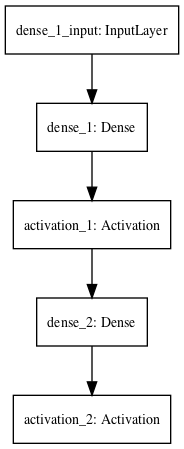

In [19]:
# save model as image
plot_model(model_cat, to_file='Images/model_cat_old.png')
Image("Images/model_cat_old.png")

In [20]:
X_train_cat # 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
model_cat.fit(X_train_cat, keras.utils.to_categorical(Y_train, num_classes=None),
          epochs=20,
          batch_size=128)

Epoch 1/20
21165/21165 [==============================] - 0s 18us/step - loss: 1.1636 - acc: 0.5965
Epoch 2/20
21165/21165 [==============================] - 0s 9us/step - loss: 0.8098 - acc: 0.7575
Epoch 3/20
21165/21165 [==============================] - 0s 9us/step - loss: 0.6989 - acc: 0.7575
Epoch 4/20
21165/21165 [==============================] - 0s 10us/step - loss: 0.6707 - acc: 0.7575
Epoch 5/20
21165/21165 [==============================] - 0s 9us/step - loss: 0.6555 - acc: 0.7575
Epoch 6/20
21165/21165 [==============================] - 0s 9us/step - loss: 0.6455 - acc: 0.7575
Epoch 7/20
21165/21165 [==============================] - 0s 9us/step - loss: 0.6376 - acc: 0.7575
Epoch 8/20
21165/21165 [==============================] - 0s 12us/step - loss: 0.6312 - acc: 0.7575
Epoch 9/20
21165/21165 [==============================] - 0s 12us/step - loss: 0.6262 - acc: 0.7575
Epoch 10/20
21165/21165 [==============================] - 0s 9us/step - loss: 0.6219 - acc: 0.7588
Epoch

In [22]:
score = model_cat.evaluate(X_test_cat2, keras.utils.to_categorical(Y_test, num_classes=None), batch_size=128)
score

20916/20916 [==============================] - 0s 6us/step


[0.6073189257754722, 0.76754637597441144]

### Categorical model in way that can be combined with other models
Also see: https://keras.io/getting-started/functional-api-guide/

In [23]:

from keras.layers import Input, Dense
from keras.models import Model
# This returns a tensor
inputs = Input(shape=(41,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(4, activation='relu')(inputs)
x = Dense(4, activation='relu')(x)
x = Dense(4, activation='tanh')(x)
predictions = Dense(4, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model_cat_new = Model(inputs=inputs, outputs=predictions)
model_cat_new.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['mse','accuracy']) #accuracy
model_cat_new.fit(X_train_cat, keras.utils.to_categorical(Y_train, num_classes=None),epochs=10) 

Epoch 1/10
21165/21165 [==============================] - 1s 48us/step - loss: 0.8354 - mean_squared_error: 0.1107 - acc: 0.7432
Epoch 2/10
21165/21165 [==============================] - 1s 37us/step - loss: 0.6550 - mean_squared_error: 0.0896 - acc: 0.7584
Epoch 3/10
21165/21165 [==============================] - 1s 38us/step - loss: 0.6340 - mean_squared_error: 0.0871 - acc: 0.7669
Epoch 4/10
21165/21165 [==============================] - 1s 41us/step - loss: 0.6199 - mean_squared_error: 0.0855 - acc: 0.7704
Epoch 5/10
21165/21165 [==============================] - 1s 40us/step - loss: 0.6105 - mean_squared_error: 0.0845 - acc: 0.7717
Epoch 6/10
21165/21165 [==============================] - 1s 36us/step - loss: 0.6058 - mean_squared_error: 0.0840 - acc: 0.7736
Epoch 7/10
21165/21165 [==============================] - 1s 35us/step - loss: 0.6033 - mean_squared_error: 0.0837 - acc: 0.7736
Epoch 8/10
21165/21165 [==============================] - 1s 40us/step - loss: 0.6013 - mean_squa

In [24]:
model_cat_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 41)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 168       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 20        
Total params: 228
Trainable params: 228
Non-trainable params: 0
_________________________________________________________________


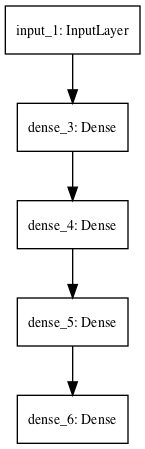

In [25]:
# save model as image
plot_model(model_cat_new, to_file='Images/model_cat_new.png')
Image("Images/model_cat_new.png")

## Continious model

In [26]:
#normalize input? log(1+x) - z score? - (x - mu - sigma)


In [27]:
model_con = Sequential()
#model_con.add(Dense(4,input_dim = 7)) 
model_con.add(Dense(4,input_dim = 7,activation = 'relu')) 
#model_con.add(Activation('relu')) #add drop out?
#model_con.add(Activation('softmax')) #add drop out?
#model_con.add(Dense(4)) #4
model_con.add(Dense(40, activation = 'tanh' ))
model_con.add(Dense(40, activation = 'relu' ))
model_con.add(Dense(4, activation = 'softmax' ))
#model_con.add(Activation('softmax')) #add drop out?
#model_con.add(Activation('relu')) #add drop out?

model_con.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', # categorical cross # nic: MSE
              metrics=['mse','accuracy'])

In [28]:
model_con.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 4)                 32        
_________________________________________________________________
dense_8 (Dense)              (None, 40)                200       
_________________________________________________________________
dense_9 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 164       
Total params: 2,036
Trainable params: 2,036
Non-trainable params: 0
_________________________________________________________________


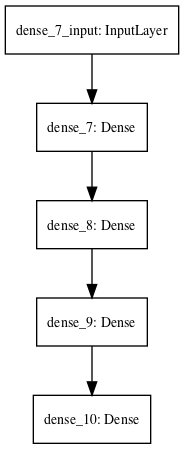

In [29]:
plot_model(model_con, to_file='Images/model_con.png')
Image("Images/model_con.png")


In [30]:
#show inputdat:

X_train_con
keras.utils.to_categorical(Y_train, num_classes=None)
save_Y_train.head()
save_Y_train['veracity_num'].unique()

# why loss nan -> acc zero
# do I have to normalize x input
# Is y variable in [0,0,0,1] good?


array([2, 1, 3])

In [31]:
model_con.fit(X_train_con, keras.utils.to_categorical(Y_train, num_classes=None),
          epochs=20,
          batch_size=128
         )

Epoch 1/20
21165/21165 [==============================] - 1s 24us/step - loss: nan - mean_squared_error: nan - acc: 0.0164
Epoch 2/20
21165/21165 [==============================] - 0s 11us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 3/20
21165/21165 [==============================] - 0s 12us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 4/20
21165/21165 [==============================] - 0s 11us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 5/20
21165/21165 [==============================] - 0s 11us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 6/20
21165/21165 [==============================] - 0s 11us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 7/20
21165/21165 [==============================] - 0s 13us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 8/20
21165/21165 [==============================] - 0s 16us/step - loss: nan - mean_squared_error: nan - acc:

In [32]:
score_con = model_con.evaluate(X_test_con, keras.utils.to_categorical(Y_test, num_classes=None), batch_size=128)
score_con

20916/20916 [==============================] - 0s 12us/step


[nan, nan, 0.0]

# Combined continious and categorical model

In [33]:
#main_input = Input(shape=(100,), dtype='int32', name='main_input') #Example
#main_input = Input(input_dim=7, dtype='int32', name='Categorial_input') # not working
cat_input = Input(shape=(41,), name='Categorial_input') # not sure whether this is the good shape(X_train_con.shape)
con_input = Input(shape=(7,), name='Continous_input')

#lstm_input = ??

x = keras.layers.concatenate([cat_input, con_input])
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

main_output = Dense(4, activation='softmax', name='main_output')(x) # from example # 1, 3 or 4

In [34]:
model_total = Model(inputs=[cat_input, con_input], outputs=[main_output])

In [35]:
model_total.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Categorial_input (InputLayer)   (None, 41)           0                                            
__________________________________________________________________________________________________
Continous_input (InputLayer)    (None, 7)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 48)           0           Categorial_input[0][0]           
                                                                 Continous_input[0][0]            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 64)           3136        concatenate_1[0][0]              
__________

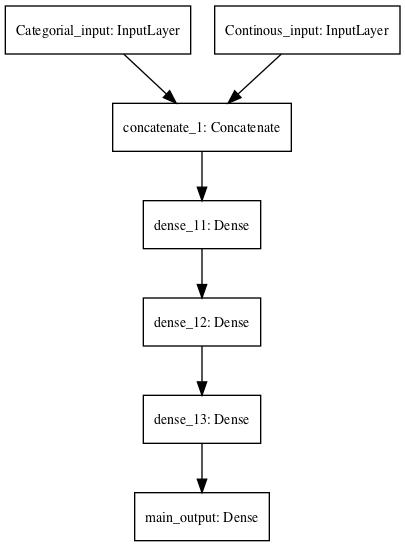

In [36]:
plot_model(model_total, to_file='Images/model_combined.png')
from IPython.display import Image
Image("Images/model_combined.png")


In [37]:
model_total.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['mse','accuracy']) # but you need multiple loss function don't you? # categocial!!!!

In [38]:
model_total.fit([X_train_cat, X_train_con], keras.utils.to_categorical(Y_train, num_classes=None),
          epochs=20, batch_size=32)

Epoch 1/20
21165/21165 [==============================] - 1s 68us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 2/20
21165/21165 [==============================] - 1s 55us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 3/20
21165/21165 [==============================] - 1s 44us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 4/20
21165/21165 [==============================] - 1s 42us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 5/20
21165/21165 [==============================] - 1s 43us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 6/20
21165/21165 [==============================] - 1s 50us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 7/20
21165/21165 [==============================] - 1s 50us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 8/20
21165/21165 [==============================] - 1s 48us/step - loss: nan - mean_squared_error: nan - 